# 1. Introduction

This notebook demonstrates the application of an IGANN-IT model using the catelematic dataset, a synthetic dataset of Canadian auto insurance telematics.

Source: https://www2.math.uconn.edu/~valdez/data.html

Reference: Banghee So, Jean-Philippe Boucher, and Emiliano A. Valdez (2021), Synthetic Dataset Generation of Driver Telematics, Risks 9:58, doi:10.3390/risks9040058.



# 2. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from interpret.glassbox import ExplainableBoostingRegressor
from pathlib import Path
import importlib

import igann
importlib.reload(igann)
from igann import IGANN

%load_ext autoreload
%autoreload 2

# 3. Load Data

In [2]:
cat = pd.read_csv('/Users/maximilianveitl/Documents/Studium/Master/3. Semester/Masterarbeit/catelematic13.csv')
cat.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609,Urban,6213.71,25,...,1,0,0,3,1,0,0,0,1,5100.171753
1,182,44,Female,3,Married,Commute,575,Urban,12427.42,20,...,58,24,11,1099,615,219,101,40,1,883.554840
2,184,48,Female,6,Married,Commute,847,Urban,12427.42,14,...,0,0,0,0,0,0,0,0,0,0.000000
3,183,71,Male,6,Married,Private,842,Urban,6213.71,43,...,0,0,0,0,0,0,0,0,0,0.000000
4,183,84,Male,10,Married,Private,856,Urban,6213.71,65,...,2,0,0,325,111,18,4,2,0,0.000000


In [3]:
X = cat[['Duration', 'Insured.age', 'Insured.sex', 'Car.age', 'Car.use', 'Credit.score', 'Region', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']]
y = cat['AMT_Claim']

In [4]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
continuous_features = ['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']

# scale data
scaler = StandardScaler()
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train_num = scaler.fit_transform(X_train[continuous_features])
X_test_num = scaler.transform(X_test[continuous_features])

X_train_cat = X_train.drop(columns=continuous_features)
X_test_cat = X_test.drop(columns=continuous_features)

X_train = pd.concat([pd.DataFrame(X_train_num, columns=continuous_features), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_num, columns=continuous_features), X_test_cat.reset_index(drop=True)], axis=1)

y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# 4. Setup Model

In [5]:
model = IGANN(task='regression', n_hid=10, n_estimators=1000, igann_it=True, interaction_detection_method='rulefit')

# 5. Train Model

In [6]:
model.fit(X_train, y_train)

# 6. Evaluate Model

## 6.1 MSE and R^2

In [7]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.7692729062006848
R^2 Score: 0.019351470417527272


## 6.2 Visualization Learning Curve

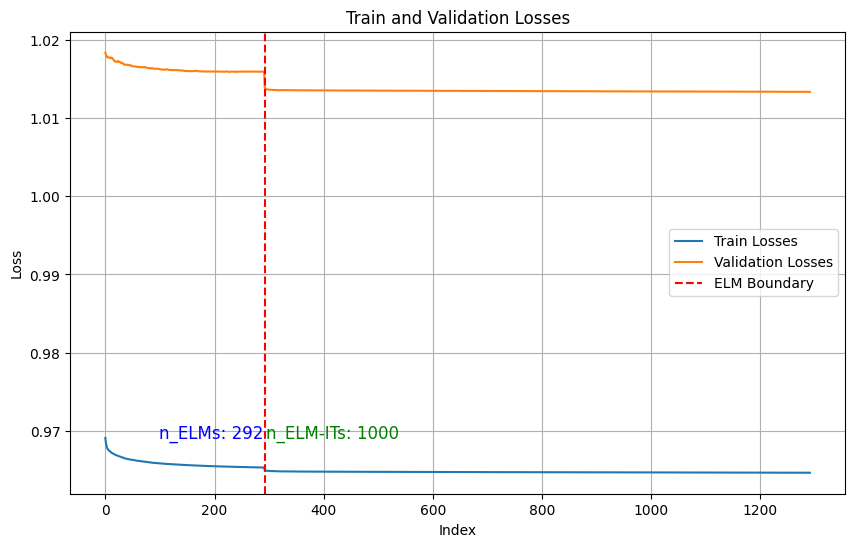

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

## 6.3 Visualization Cumulative Interaction Effect

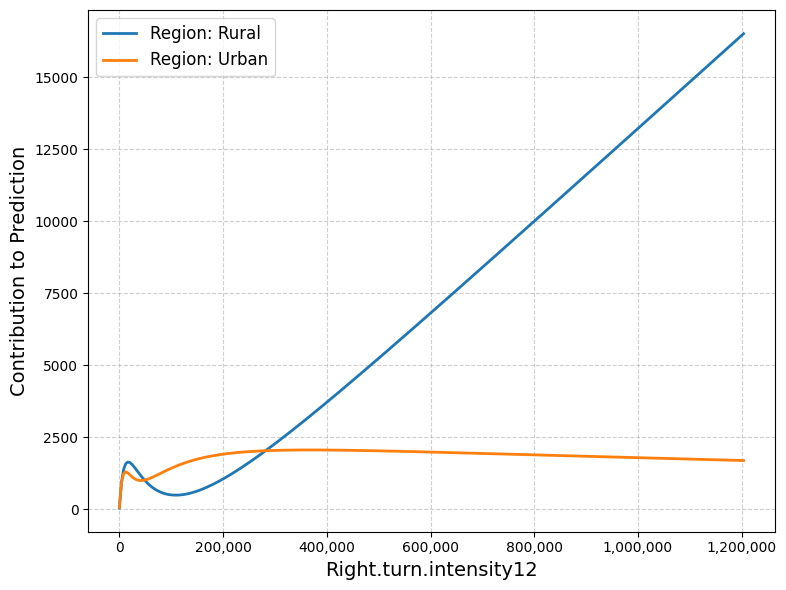

In [9]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, cumulative=True)

## 6.4 Visualization Single Interaction Effect

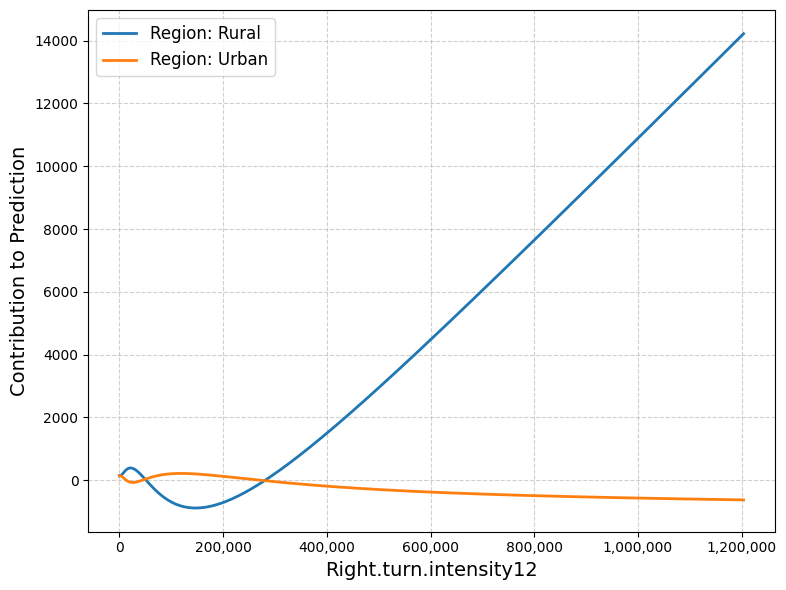

In [10]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, cumulative=False)

## 6.5 Visualization Most Important Main Effects

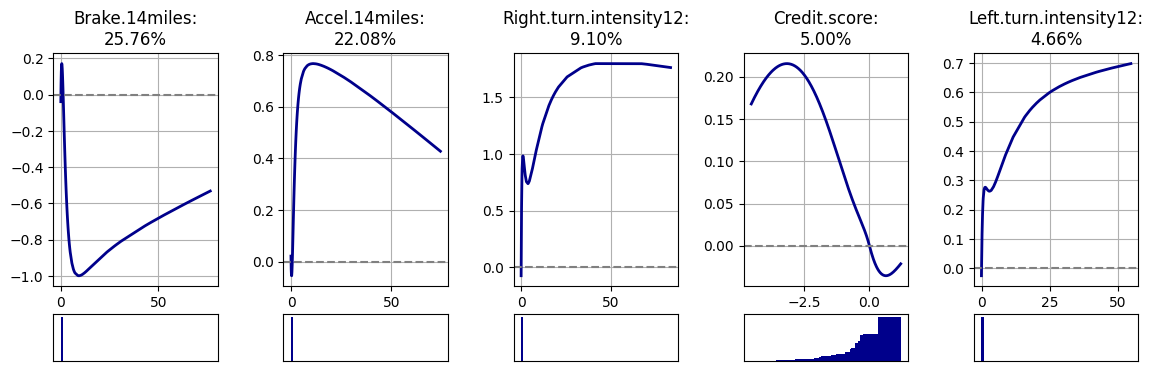

In [11]:
model.plot_single()